# Pipeline for the anomaly detection on the SKAB using LSTM-based NN

In [1]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../utils')

## Data loading

In [2]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [3]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

## Data description and visualization

We are working now with SKAB v0.9. The current version of SKAB (v0.9) contains 34 datasets with collective anomalies. But the update to v1.0 will contain 300+ additional files with point and collective anomalies.

In [4]:
# dataset characteristics printing
print(f'A number of datasets in the SKAB v0.9: {len(list_of_df)}\n')
print(f'Shape of the random dataset: {list_of_df[0].shape}\n')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'A number of changepoints in the SKAB v0.9: {n_cp}\n')
print(f'A number of outliers in the SKAB v0.9: {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head())

A number of datasets in the SKAB v0.9: 34

Shape of the random dataset: (1154, 10)

A number of changepoints in the SKAB v0.9: 129

A number of outliers in the SKAB v0.9: 13067

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 12:14:36,0.027429,0.040353,0.770310,0.382638,71.2129,25.0827,219.789,32.0000,0.0,0.0
2020-03-09 12:14:37,0.027269,0.040226,1.096960,0.710565,71.4284,25.0863,233.117,32.0104,0.0,0.0
2020-03-09 12:14:38,0.027040,0.039773,1.140150,0.054711,71.3468,25.0874,234.745,32.0000,0.0,0.0
2020-03-09 12:14:39,0.027563,0.040313,1.108680,-0.273216,71.3258,25.0897,205.254,32.0104,0.0,0.0
2020-03-09 12:14:41,0.026570,0.039566,0.704404,0.382638,71.2725,25.0831,212.095,33.0000,0.0,0.0


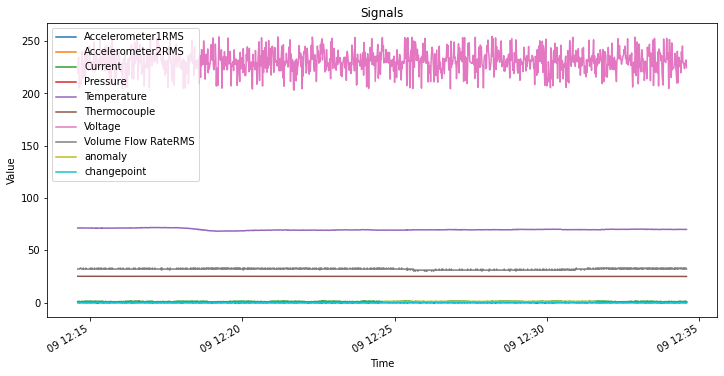

In [5]:
# random dataset visualizing
list_of_df[0].plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

## Labels

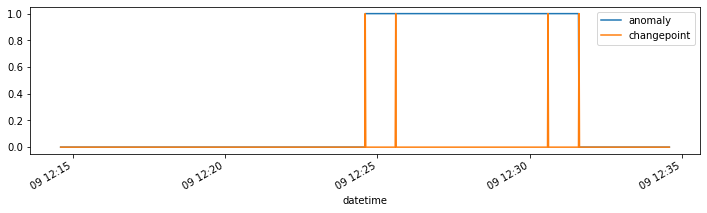

In [6]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[0].anomaly.plot(figsize=(12,3))
list_of_df[0].changepoint.plot()
plt.legend()
plt.show()

## Method applying

In [8]:
!pip install tensorflow

     |████████████████████████████████| 228.5 MB 95 kB/s  eta 0:00:01    |███▏                            | 22.8 MB 387 kB/s eta 0:08:52     |█████▉                          | 41.3 MB 445 kB/s eta 0:07:00     |███████████████▊                | 112.1 MB 465 kB/s eta 0:04:10     |█████████████████████████████   | 207.1 MB 485 kB/s eta 0:00:45     |█████████████████████████████▋  | 211.5 MB 432 kB/s eta 0:00:40
     |████████████████████████████████| 1.6 MB 1.4 MB/s eta 0:00:01
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     |████████████████████████████████| 5.8 MB 2.0 MB/s eta 0:00:01
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
     |████████████████████████████████| 1.6 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 438 kB 25.3 MB/s eta 0:00:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
     |███████████████

In [ ]:
# libraries importing
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [ ]:
# Function for repeatability
def Random(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

In [9]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

### Training once in the beginning

In [10]:
# StSc = StandardScaler()
# # scaler fitting
# StSc.fit(X_train)

In [11]:
# N_STEPS = 5
# epochs = 25
# batch_size = 32

# # convert into input/output
# X, y = split_sequences(StSc.transform(X_train), N_STEPS)
# # the dataset knows the number of features, e.g. 2
# n_features = X.shape[2]
# # define model
# model = Sequential()
# model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(N_STEPS, n_features)))
# model.add(LSTM(200, activation='relu'))
# model.add(Dense(n_features))
# model.compile(optimizer='adam', loss='mae', metrics=["mse"])

In [12]:
# model.summary()

In [13]:
# early_stopping = EarlyStopping(patience=10, verbose=1)
# model_checkpoint = ModelCheckpoint("lstm.h5", save_best_only=True, verbose=0, save_weights_only=True)
# reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1)

# history = model.fit(X, y,
#                     validation_split=0.2,
#                     epochs=epochs,
#                     batch_size=batch_size,
#                     verbose=2,
#                     shuffle=False,
#                     callbacks=[early_stopping, model_checkpoint, reduce_lr]
#                     )

In [14]:
# fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(12,6))
# ax_loss.plot(history.epoch, history.history["loss"], label="Train mae (loss)")
# ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation mae (loss)")
# ax_loss.grid()
# ax_loss.legend()

# ax_acc.plot(history.epoch, history.history["mse"], label="Train mse")
# ax_acc.plot(history.epoch, history.history["val_mse"], label="Validation mse")
# ax_acc.grid()
# ax_acc.legend()
# plt.show()

In [15]:
# model.load_weights("lstm.h5")

In [16]:
# residuals = pd.DataFrame(y - model.predict(X)).abs().sum(axis=1)

# UCL = residuals.quantile(0.99)

In [17]:
# residuals.plot(figsize=(12,6))
# plt.axhline(UCL, color='r')

### Training in the beginning of each dataset

In [ ]:
N_STEPS = 5
EPOCHS = 25
BATCH_SIZE = 32
VAL_SPLIT = 0.2

In [ ]:
# model defining
model = Sequential()
model.add(LSTM(100, 
               activation='relu', 
               return_sequences=True, 
               input_shape=(N_STEPS, n_features)))
model.add(LSTM(100, 
               activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', 
              loss='mae', 
              metrics=["mse"])

In [ ]:
history = model.fit(X, y,
                    validation_split=VAL_SPLIT,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=0,
                    shuffle=False,
                    )

In [ ]:
# results predicting
residuals = pd.DataFrame(y - model.predict(X)).abs().sum(axis=1)
UCL = residuals.quantile(0.99)

In [18]:
# hyperparameters selection
N_STEPS = 5
EPOCHS = 25
BATCH_SIZE = 32
VAL_SPLIT = 0.2

# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X, y = split_sequences(StSc.transform(X_train), N_STEPS)
    
    # the dataset knows the number of features
    n_features = X.shape[2]
    
    # model defining
    model = Sequential()
    model.add(LSTM(100, 
                   activation='relu', 
                   return_sequences=True, 
                   input_shape=(N_STEPS, n_features)))
    model.add(LSTM(100, 
                   activation='relu'))
    model.add(Dense(n_features))
    model.compile(optimizer='adam', 
                  loss='mae', 
                  metrics=["mse"])
    
    # callbacks defining
    early_stopping = EarlyStopping(patience=10, verbose=0)
    model_checkpoint = ModelCheckpoint("lstm.h5", save_best_only=True, verbose=0, save_weights_only=True)
    reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=0)
    
    # model fitting
    history = model.fit(X, y,
                        validation_split=VAL_SPLIT,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=0,
                        shuffle=False,
                        callbacks=[early_stopping, model_checkpoint, reduce_lr]
                        )
    
    # loading the best saved weights
    model.load_weights("lstm.h5")
    
    # results predicting
    residuals = pd.DataFrame(y - model.predict(X)).abs().sum(axis=1)
    UCL = residuals.quantile(0.99)
    
    # results predicting
    X, y = split_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    lstm_residuals = pd.DataFrame(y - model.predict(X)).abs().sum(axis=1)
    prediction = pd.Series((lstm_residuals>3/2*UCL).astype(int).values, 
                                index=df[N_STEPS:].index).fillna(0)
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

### Results

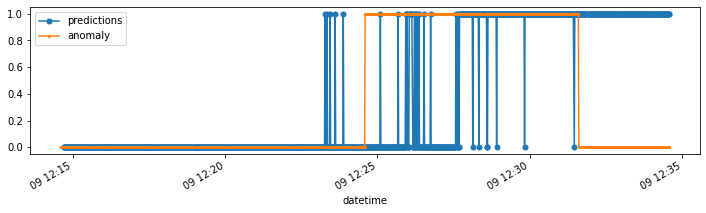

In [19]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend();

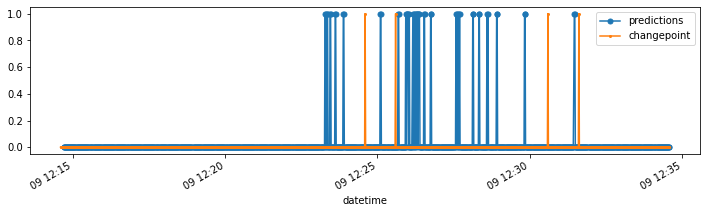

In [20]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

## Metrics calculation

In [21]:
# binary classification metrics calculation
binary = evaluating_change_point(true_outlier, predicted_outlier, metric='binary', numenta_time='30 sec')

False Alarm Rate 15.4 %
Missing Alarm Rate 39.93 %
F1 metric 0.64


In [22]:
# average detection delay metric calculation
add = evaluating_change_point(true_cp, predicted_cp, metric='average_delay', numenta_time='30 sec')

Average delay 0 days 00:00:09.232142857
A number of missed CPs = 74


In [23]:
# nab metric calculation
nab = evaluating_change_point(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')

Intersection of the windows of too wide widths for dataset 16
Intersection of the windows of too wide widths for dataset 16
Intersection of the windows of too wide widths for dataset 16
Intersection of the windows of too wide widths for dataset 18
Intersection of the windows of too wide widths for dataset 18
Intersection of the windows of too wide widths for dataset 18
Intersection of the windows of too wide widths for dataset 19
Intersection of the windows of too wide widths for dataset 19
Intersection of the windows of too wide widths for dataset 19
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 27
Intersec

## [Additional] localization